<big> Here we build a <b>feedforward Neural Network</b> made up of <b>Fully Connected</b> layers (called <b>Dense</b> layers in Keras)<br>

Tensorflow improves the coding efficiency<br>
Code becomes much more<l>
<li>Readable;
<li>Easier to understand
<li>Easier to modify and adapt.
</l><br>

It also allows to use <b>GPU acceleration</b>, in the case you have a GPU available and correct drivers and libraries.<br>
The <b>Keras API</b> is a high-level API for building and training deep learning models leveraging TensorFlow.<br>

In [ ]:
# Some libraries - do not worry about them
import numpy as np
from matplotlib import pyplot as plt
import tensorflow
from tensorflow import keras
from keras.layers import Dense, Input
from keras import optimizers
from keras.callbacks import EarlyStopping

# additional libraries - useful to download code and data from GitHub folder
import requests
import types
from urllib.request import urlopen

# URL of the GitHub repository and the module name
git_path = 'https://raw.githubusercontent.com/Nemenick/FCA_DeepNeuralNework-with-TensorFlow/main/'
module_name = 'Ising2d'
# Download the code
response = requests.get(git_path + module_name + ".py")
code = response.text
# Create a module object
Ising2d = types.ModuleType(module_name)
exec(code, Ising2d.__dict__)

Termalizza = Ising2d.Termalizza  # funzione che mi termalizza 1 sola configurazione in 2D

# Generate (or Load) my Data


<ul>
<li>a name of an example file accepted is 35conf4.dat<br>
<li>Here 35 corresponds to the number of spin per dimension (35x35)</li>
<li>and 4 corresponds to ntrain (or ntest or nval...) and it is the number of Temperature used.</li>
<li>For each temperature I sample 20 configuration, so in 35conf4.dat i have 4x20=80 spin conf. (1 conf. is 1 raw)</li>
<li>TODO read_file = True only if alredy generated my config.: "(n)conf(ntrain).dat" and "(n)conf(ntest).dat" alredy present</li>
<li>TODO if readfile = false at first I generate my configurations (it takes a while...)</li>
</ul>

In [ ]:
# Some initial parameters
n=35                # number of spins in one direction
ntrain=14           # number of training configurations
nval=12             # number of validation configurations
ntest=10            # number of test configurations
read_file=True      # if True read the configurations from file, if False generate them. The configurations to be read must exist somewhere...

In [ ]:
data, data_val, data_test = [], [], []
y, y_val, y_test = [], [], []
if not read_file:
    # In this section I generate my data rather than loading them
    t = [0.1 + 3 / ntrain * i for i in range(ntrain // 2)] + [4 + 40 / ntrain * i for i in range(ntrain // 2)]
    tc = 2 / np.log(1 + np.sqrt(2))
    for temp in t:
        spin = Termalizza(temp, L=n)
        for _ in range(10):
            if temp < tc:
                y.append(0)
            else:
                y.append(1)
            data.append([])
            Termalizza(temp, L=n, spin=spin, equilibrato=True)
            for i in range(n):
                for j in range(n):
                    data[-1].append(spin[i + 1][j + 1])
    print("Ho generato tutte le \"training\" configurazioni")
    data = np.array(data)

    # Now i generate validation data
    t = [0.1 + 3 / nval * i for i in range(nval // 2)] + [4 + 40 / nval * i for i in range(nval // 2)]
    tc = 2 / np.log(1 + np.sqrt(2))
    for temp in t:
        spin = Termalizza(temp, L=n)
        for _ in range(10):
            if temp < tc:
                y_val.append(0)
            else:
                y_val.append(1)
            data_val.append([])
            Termalizza(temp, L=n, spin=spin, equilibrato=True)
            for i in range(n):
                for j in range(n):
                    data_val[-1].append(spin[i + 1][j + 1])
    print("Ho generato tutte le \"training\" configurazioni")
    data_val = np.array(data_val)

    # Now i generate my test data
    t = [0.1 + 3 / nval * i for i in range(nval // 2)] + [4 + 40 / nval * i for i in range(nval // 2)]
    tc = 2 / np.log(1 + np.sqrt(2))
    for temp in t:
        spin = Termalizza(temp, L=n)
        for _ in range(10):
            if temp < tc:
                y_test.append(0)
            else:
                y_test.append(1)
            data_test.append([])
            Termalizza(temp, L=n, spin=spin, equilibrato=True)
            for i in range(n):
                for j in range(n):
                    data_test[-1].append(spin[i + 1][j + 1])
    print("Ho generato tutte le \"training\" configurazioni")
    data_test = np.array(data_test)

else:
    # if read_file I load my data than generating them! (files have to exist before I lunch this section)
    data = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntrain) + ".dat"))
    y = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntrain) + "y.dat"))

    data_val = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(nval) + ".dat"))
    y_val = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(nval) + "y.dat"))


    data_test = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntest) + ".dat"))
    y_test = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntest) + "y.dat"))



# Data inspection


In [ ]:
print(data.shape)
print(data_val.shape)
print(data_test.shape)

(280, 1225)
(240, 1225)
(200, 1225)


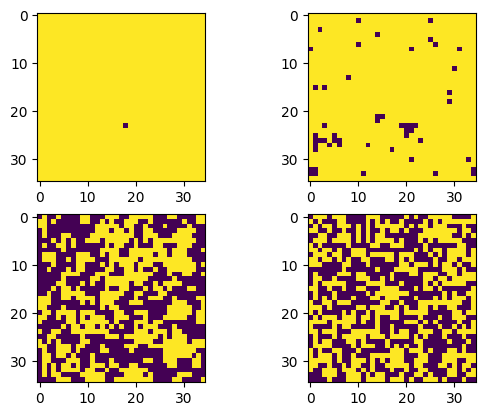

In [ ]:
index1 = 50
index2 = 135
index3 = 141
index4 = 269
data_inspected1 = data[index1].reshape(n,n)
data_inspected2 = data[index2].reshape(n,n)
data_inspected3 = data[index3].reshape(n,n)
data_inspected4 = data[index4].reshape(n,n)

fig, ax = plt.subplots(2,2)
ax[0][0].imshow(data_inspected1)
ax[0][1].imshow(data_inspected2)
ax[1][0].imshow(data_inspected3)
ax[1][1].imshow(data_inspected4)





# Data Augmentation (optional)


Here, we extract as much as possible from our existing data!<br>
Data augmentation is the process of creating new training data by applying transformations (rotation, flipping, noise...) to existing data to improve model robustness and generalization.<br>

Physics analogy: exploiting all symmetries of the system.

In [ ]:
data_flipped = -data
y_flipped = 1-y

data = np.concatenate((data,data_flipped))
y = np.concatenate((y,y_flipped))

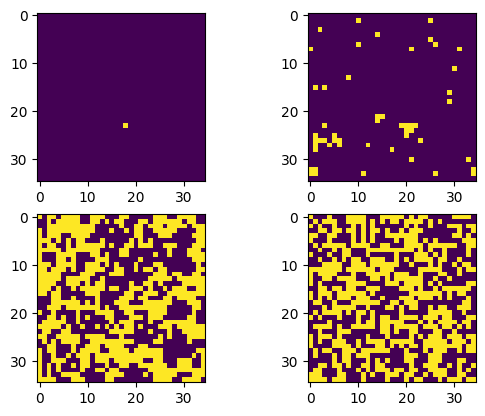

In [ ]:
index1 = 50
index2 = 135
index3 = 141
index4 = 269
data_inspected_flipped1 = data_flipped[index1].reshape(n,n)
data_inspected_flipped2 = data_flipped[index2].reshape(n,n)
data_inspected_flipped3 = data_flipped[index3].reshape(n,n)
data_inspected_flipped4 = data_flipped[index4].reshape(n,n)

fig, ax = plt.subplots(2,2)
ax[0][0].imshow(data_inspected_flipped1)
ax[0][1].imshow(data_inspected_flipped2)
ax[1][0].imshow(data_inspected_flipped3)
ax[1][1].imshow(data_inspected_flipped4)

# Build and train my network
Neural network made up of only FullyConnected layers (or Dense layers)<br>
The TensorFlow implementation is very fast during training and it is very easy to generalize<br>

Try to:
<ul>
<li> Change the hidden layer size and study the effect [(2), (5), (10), (25)]</li>
<li> Add more layers. For example add the line "Dense(5, activation="relu")," after the first Dense layer</li>
<li> Add Early Stopping</li>
<li> Change activation function of hidden layers: sigmoid -> relu</li>
</ul>


In [ ]:
rete1 = tensorflow.keras.models.Sequential([
    Input(shape=(data.shape[1],)),
    Dense(1, activation="sigmoid")])

# Parameters of the SGD optimizer
lr = 0.002

rete1.compile(
    optimizer=optimizers.SGD(learning_rate=lr),
    loss="binary_crossentropy",
    metrics=['accuracy'])
rete1.summary()

# Exercise: compute the number of parameters in the model

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 100)            │       122,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,621 (482.89 KB)

 Trainable params: 123,621 (482.89 KB)

 Non-trainable params: 0 (0.00 B)

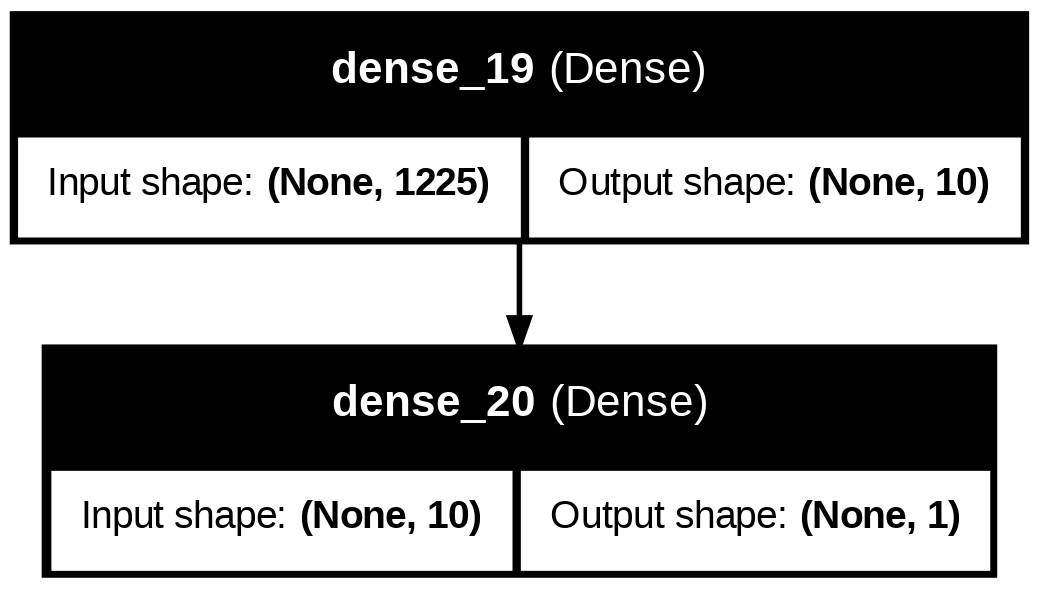

In [ ]:
keras.utils.plot_model(rete1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Start my training -
batches, epoche, pazienza = 32, 120, 5
storia = rete1.fit(data, y,
                    batch_size=batches,
                    epochs=epoche,
                    validation_data=(data_val, y_val),
                   callbacks=EarlyStopping(patience=pazienza, min_delta=0.005, restore_best_weights=True)
                    ) #callbacks=EarlyStopping(patience=pazienza, min_delta=0.005, restore_best_weights=True)

print("\n",storia.history.keys())

Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.1046 - val_accuracy: 0.7625 - val_loss: 0.7390
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 0.7542 - val_loss: 0.7359
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.7500 - val_loss: 0.7394
Epoch 4/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.7542 - val_loss: 0.7374
Epoch 5/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.7542 - val_loss: 0.7325
Epoch 6/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.7542 - val_loss: 0.7262
Epoch 7/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.7542 - val_loss: 0.7198
Epoch 8/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.7542 - val_loss:

# Plots of training history and test my network

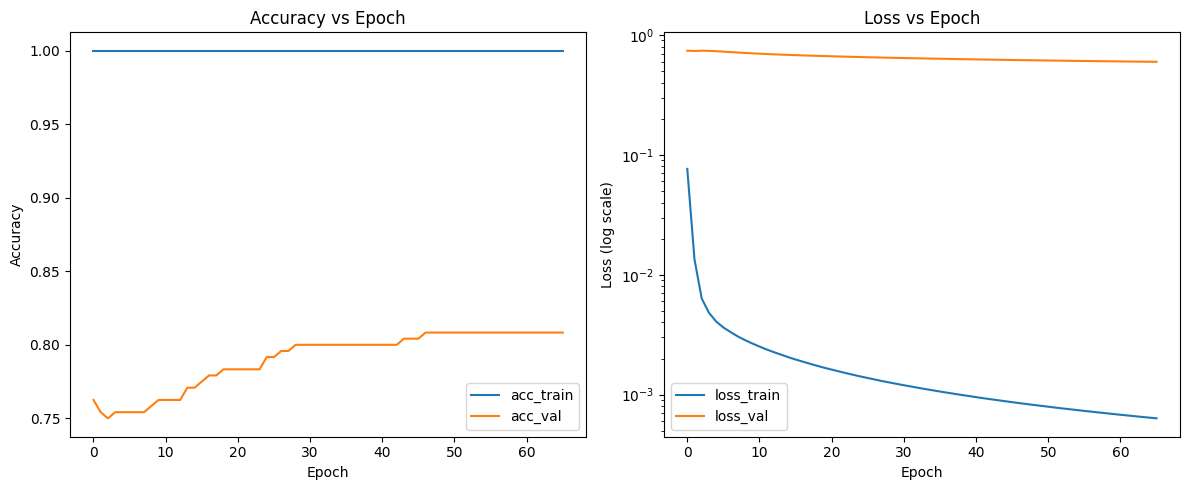

In [ ]:
"""################################################### Plots ####################################################"""

loss_train = storia.history["loss"]
loss_val = storia.history["val_loss"]
acc_train = storia.history["accuracy"]
acc_val = storia.history["val_accuracy"]

# Create a figure with 2 subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy on the first axis (ax1)
ax1.plot(range(len(acc_train)), acc_train, label="acc_train")
ax1.plot(range(len(acc_val)), acc_val, label="acc_val")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Epoch')
ax1.legend()

# Plot Loss on the second axis (ax2)
ax2.plot(range(len(loss_train)), loss_train, label="loss_train")
ax2.plot(range(len(loss_val)), loss_val, label="loss_val")
ax2.set_yscale('log')  # Log scale for loss
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss (log scale)')
ax2.set_title('Loss vs Epoch')
ax2.legend()

plt.tight_layout()


plt.savefig("Loss_Accuracy_Ising2d.png")

# Show the plot
plt.show()



In [ ]:
"""################################################### Test ####################################################"""

 # make my predictions on the test set
yp_test = rete1.predict(data_test)
yp_ok_test = []
for i in yp_test:
    yp_ok_test.append(i[0])
yp_ok_test = np.array(yp_ok_test)

total_predictions = len(y_test)
correct_predictions = 0
erroneous_predictions = 0

# calculating the total, erroneous and correct predictions
for i in range(total_predictions):
    if abs(y_test[i] - yp_ok_test[i]) < 0.5:
        correct_predictions = correct_predictions + 1
    else:
        erroneous_predictions = erroneous_predictions + 1

print("test predictions:\ntotal/correct/erroneous:\n", total_predictions, "/", correct_predictions, "/", erroneous_predictions, "/")
print("test Accuracy= ", correct_predictions / total_predictions)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
test predictions:
total/correct/erroneous:
 200 / 156 / 44 /
test Accuracy=  0.78


# Tests

In [ ]:
import numpy as np
from urllib.request import urlopen

git_path = 'https://raw.githubusercontent.com/Nemenick/AIPHY24_GNN_Giagu/main/35conf10.dat'

response = urlopen(git_path)
data = np.loadtxt(response)

print(data)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1.  1. -1.]
 [-1. -1.  1. ... -1. -1.  1.]
 [ 1.  1. -1. ... -1. -1.  1.]]


In [ ]:
git_path = 'https://raw.githubusercontent.com/Nemenick/FCA_DeepNeuralNework-with-TensorFlow/main/'
# if read_file I load my data than generating them! (files have to exist before I lunch this section)
# file = open(git_path + str(n) + "conf" + str(ntrain) + ".dat", "r")
# file_y = open(git_path + str(n) + "conf" + str(ntrain) + "y.dat", "r")
data = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntrain) + ".dat"))
y = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntrain) + "y.dat"))

# file = open(git_path + str(n) + "conf" + str(nval) + ".dat", "r")
# file_y = open(str(n) + "conf" + str(nval) + "y.dat", "r")
data_val = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(nval) + ".dat"))
y_val = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(nval) + "y.dat"))

# file = open(git_path + str(n) + "conf" + str(ntest) + ".dat", "r")
# file_y = open(git_path + str(n) + "conf" + str(ntest) + "y.dat", "r")
data_test = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntest) + ".dat"))
y_test = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntest) + "y.dat"))

In [ ]:
git_path

'https://raw.githubusercontent.com/Nemenick/AIPHY24_GNN_Giagu/main/35conf10.dat'

In [ ]:
response